# Test for Satellite Image Segmentation Inference

Author: Ivan Zvonkov, inspired by Kartik's training colab notebook.

Description: Tests satellite image segmentation model deployed in gcp/inference_satellite

Date: Nov 8, 2023

In [97]:
import os

from pathlib import Path
from typing import Tuple

import cv2
import numpy as np
import re
import sys
import tempfile
import torch

from matplotlib import pyplot as plt
from google.cloud import storage, firestore

In [98]:
temp_dir = tempfile.gettempdir()

os.environ["LRU_CACHE_CAPACITY"] = "1"

storage_client = storage.Client()
db = firestore.Client()
device = "cuda" if torch.cuda.is_available() else "cpu"

BUCKET_IMGS_W_ARROW = "street2sat-satellite-imgs-with-arrow"
BUCKET_IMGS_W_PRED = "street2sat-satellite-imgs-predictions"
bucket_w_arrow = storage_client.get_bucket(BUCKET_IMGS_W_ARROW)
bucket_w_pred = storage_client.get_bucket(BUCKET_IMGS_W_PRED)

THRESHOLD = 0.5
RADIUS = 5

XYZ_REGEX_PATTERN = r'^.+/\d+/\d+/\d+/.+$'

In [3]:
def gamma_correction(img):
    img = img.astype(float)
    img = (
        255 * (img - np.min(img[:])) / (np.max(img[:]) - np.min(img[:]) + 0.1)
    ).astype(float)
    img = (img + 0.5) / 256
    gamma = -1 / np.nanmean(np.log(img))
    return img ** (gamma)


def get_largest_contour(pred):
    pred_mask = (pred > 0.5).astype(np.uint8)
    contours, _ = cv2.findContours(pred_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return pred
    max_contour = max(contours, key=lambda x: cv2.contourArea(x))
    new_img = np.zeros(pred.shape)
    cv2.fillPoly(new_img, pts=[max_contour], color=(1.0, 1.0, 1.0))
    return new_img * pred


def get_new_mark_pos(img):
    x, y = np.where(img > THRESHOLD)
    if len(x) == 0:
        print(f"{len(x)=}")
        return np.unravel_index(np.argmax(img), img.shape)[::-1]
    x_centr, y_centr = np.mean(x), np.mean(y)
    med_val = np.median(img[x, y])
    x_new, y_new = np.where(img >= med_val)
    z = [i for i in zip(x_new, y_new)]
    return min(z, key=lambda k: (x_centr - k[0]) ** 2 + (y_centr - k[1]) ** 2)


def mark_img(img):
    z = np.unravel_index(np.argmax(img), img.shape)[::-1]
    new_img = np.ones((*img.shape, 3)) * img.reshape((*img.shape, 1))
    cv2.circle(new_img, z, RADIUS, (0.0, 1.0, 0.0), -1)
    y1, x1 = get_new_mark_pos(img)
    cv2.circle(new_img, (x1, y1), RADIUS, (0.0, 0.0, 1.0), -1)
    return new_img, x1, y1

In [107]:
path = "bing/154881/130612/18/Uganda_v2-1829244-2020-06-24_Edrick_2-2020-06-24_Edrick_2-124GOPRO-G0181192.jpg"

In [108]:
match = re.match(r'^.+/\d+/\d+/\d+/.+$', path)

In [109]:
match

<re.Match object; span=(0, 101), match='bing/154881/130612/18/Uganda_v2-1829244-2020-06-2>

In [5]:
blob = bucket_w_arrow.blob(path)
local_path = temp_dir + "/" + path.replace("/", "_")
blob.download_to_filename(local_path)
img = cv2.imread(local_path)

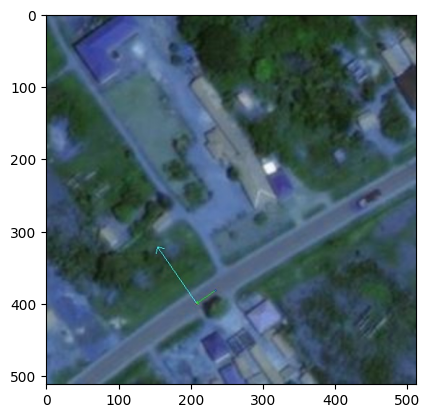

In [8]:
plt.imshow(img)
plt.show()

In [ ]:
Path(local_path).unlink()  # Remove image once read in

In [9]:
img = img[0:512, 0:512]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = gamma_correction(img)

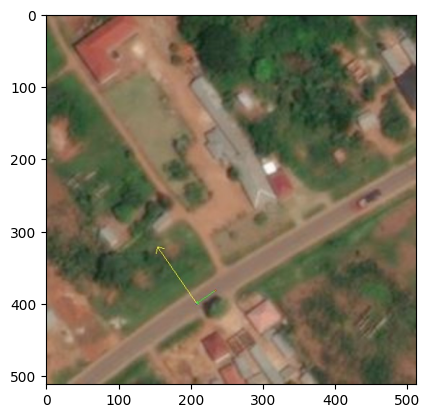

In [10]:
plt.imshow(img)
plt.show()

In [11]:
img_tensor = torch.from_numpy(img.transpose(2, 0, 1).astype("float32"))
img_tensor = img_tensor.to(device)

In [15]:
!ls ../model_weights/satellite

best_model.pth


In [17]:
model = torch.load("../model_weights/satellite/best_model.pth", map_location=device)

In [24]:
ts = torch.jit.trace(model, img_tensor.unsqueeze(0), strict=False)
ts.save("../model_weights/satellite/best_model.torchscript.pt")
model2 = torch.jit.load("../model_weights/satellite/best_model.torchscript.pt")

In [23]:
pred = model(img_tensor.unsqueeze(0))
pred_numpy = pred.detach().cpu().numpy()[0, 0]

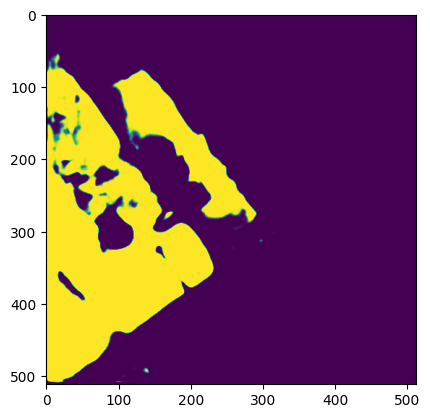

In [29]:
plt.imshow(pred_numpy);

In [26]:
pred_w_contour = get_largest_contour(pred_numpy)

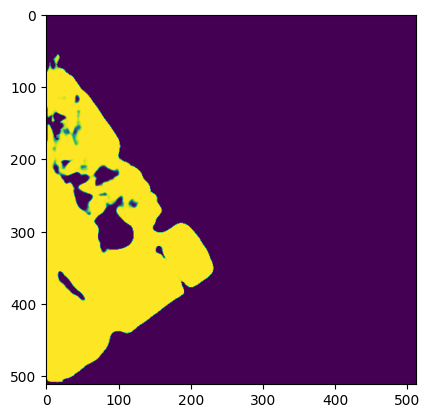

In [28]:
plt.imshow(pred_w_contour);

In [54]:
pred_w_mark, pred_x, pred_y = mark_img(pred_w_contour)

In [56]:
pred_w_mark.shape

(512, 512, 3)

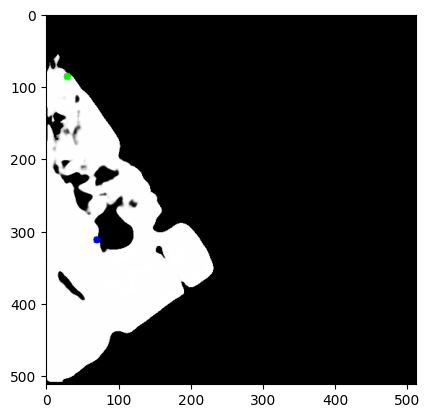

In [31]:
plt.imshow(pred_w_mark);

In [55]:
pred_x, pred_y

(70, 312)

In [33]:
path

'bing/154881/130612/18/Uganda_v2-1829244-2020-06-24_Edrick_2-2020-06-24_Edrick_2-124GOPRO-G0181192.jpg'

In [51]:
from pygeotile.tile import Point, Tile
from IPython.display import display, Image

In [40]:
splits = path.split("/")
x,y,z = [int(number) for number in splits[1:4]]
x,y,z

(154881, 130612, 18)

In [52]:
Image(url=f"https://mt0.google.com/vt/lyrs=s&hl=en&x={x}&y={y}&z={z}")

In [96]:
left_bottom_point, right_top_point = Tile.from_google(x,y,z).bounds

# CV2 image has origin (x=0, y=0) at top left
x1, y2 = left_bottom_point.pixels(zoom=z)
x2, y1 = right_top_point.pixels(zoom=z)

x_on_tile = pred_x // 2 
y_on_tile = pred_y // 2

point = Point.from_pixel(x1 + x_on_tile, y1 + y_on_tile, zoom=z)
point.latitude_longitude

(0.6308642704918179, 32.696873545646675)